In [11]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import csv
import pandas as pd
import os
import numpy as np
from numpy.linalg import norm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics as st



In [12]:
# read in training file and convert to array like matrix
#load trans clos of that DS

os.chdir('../prepped_csv')
train = pd.read_csv('alt_gold_trans_clos_embeddings.csv', header=0, sep="\t")
test = pd.read_csv('alt_test_chrystal_clos_embeddings.csv', sep='\t', header=0)


FileNotFoundError: [Errno 2] File alt_gold_trans_clos_embeddings.csv does not exist: 'alt_gold_trans_clos_embeddings.csv'

In [3]:
def poin_dist(tensor1, tensor2):
    return np.arcsinh(1 + (2*(norm(tensor1 - tensor2)))/ ((1 - norm(tensor1) ** 2)*(1 - norm(tensor2) ** 2)))

In [4]:
print(train['class label'].value_counts())
print(test['class label'].value_counts())
len(list(train['id1'].value_counts()))

0.0    14403
1.0     3849
Name: class label, dtype: int64
0.0    11849
1.0     3849
Name: class label, dtype: int64


2555

In [5]:

train['id1 freq'] = train.groupby('id1')['id1'].transform('count')
train['id2 freq'] = train.groupby('id2')['id2'].transform('count')
train.head()

,id1,id2,1_x,1_y,2_x,2_y,class label,id1 freq,id2 freq
0,249564556,209895253,-0.340766,0.715908,-0.278152,0.843449,1.0,14,1
1,250233077,186201601,0.226315,0.801542,-0.160874,-0.594917,0.0,16,871
2,252578211,186201601,0.069049,-0.990024,-0.160874,-0.594917,0.0,7,871
3,192557288,170589394,-0.669857,-0.686993,-0.668075,-0.621127,0.0,18,33
4,522426882,170589324,-0.374436,0.901481,-0.266791,0.697339,0.0,5,474


In [6]:
test['id1 freq'] = test.groupby('id1')['id1'].transform('count')
test['id2 freq'] = test.groupby('id2')['id2'].transform('count')
test.head()

,id1,id2,1_x,1_y,2_x,2_y,class label,id1 freq,id2 freq
0,186201345,189721042,-0.950052,-0.013506,-0.886165,-0.013648,0.0,69,8
1,186131996,261481841,-0.317058,-0.627595,-0.299037,-0.619111,1.0,24,8
2,186131996,261481841,-0.317058,-0.627595,-0.299037,-0.619111,1.0,24,8
3,484995553,262491683,0.322711,0.400252,0.306095,0.413837,1.0,3,7
4,186201601,253227719,-0.598286,-0.800964,-0.425721,-0.806831,0.0,871,5


In [7]:
#Change current working directory for reading processed feature files and saving intermediate computed features
os.chdir('../feature_csv')

id1_neighs = pd.read_csv('id1_neighbours.csv', sep=',',header=0)
id2_neighs = pd.read_csv('id2_neighbours.csv', sep=',',header=0)
c_train = train.merge(id1_neighs, on=['id1'],how='left')
c_train.head()

,id1,id2,1_x,1_y,2_x,2_y,class label,id1 freq,id2 freq,id1_neighs
0,249564556,209895253,-0.340766,0.715908,-0.278152,0.843449,1.0,14,1,"[189967549, 209895253, 252925068, 252925068]"
1,250233077,186201601,0.226315,0.801542,-0.160874,-0.594917,0.0,16,871,"[210630498, 210630498, 248833274, 210630498]"
2,252578211,186201601,0.069049,-0.990024,-0.160874,-0.594917,0.0,7,871,[253206593]
3,192557288,170589394,-0.669857,-0.686993,-0.668075,-0.621127,0.0,18,33,"[209895092, 248811486, 257945222, 209895092]"
4,522426882,170589324,-0.374436,0.901481,-0.266791,0.697339,0.0,5,474,[189720839]


In [8]:
#merge again on id2 to then compute n_common neighbours

c_train = c_train.merge(id2_neighs, on='id2', how='left')
c_train.head()

,id1,id2,1_x,1_y,2_x,2_y,class label,id1 freq,id2 freq,id1_neighs,id2_neighs
0,249564556,209895253,-0.340766,0.715908,-0.278152,0.843449,1.0,14,1,"[189967549, 209895253, 252925068, 252925068]",[249564556]
1,250233077,186201601,0.226315,0.801542,-0.160874,-0.594917,0.0,16,871,"[210630498, 210630498, 248833274, 210630498]","[186201345, 170589404, 210636295, 186201603]"
2,252578211,186201601,0.069049,-0.990024,-0.160874,-0.594917,0.0,7,871,[253206593],"[186201345, 170589404, 210636295, 186201603]"
3,192557288,170589394,-0.669857,-0.686993,-0.668075,-0.621127,0.0,18,33,"[209895092, 248811486, 257945222, 209895092]","[190195190, 210638310, 257947224, 257946310, 1..."
4,522426882,170589324,-0.374436,0.901481,-0.266791,0.697339,0.0,5,474,[189720839],"[170589394, 210636186, 170589400, 170589402, 1..."


In [9]:
df_out = pd.DataFrame()

for index,row in c_train.iterrows():
    left = set(row.id1_neighs)
    right = row.id2_neighs
    
    common_count = len(left.intersection(right))
    c_train['n_comm_neighs'] = df_out.append([common_count])

val = {'n_comm_neighs':0}
train = c_train.fillna(value=val)

In [10]:
c_test = test.merge(id1_neighs, on=['id1'],how='left')
c_test = c_test.merge(id2_neighs, on='id2', how='left')

df_out = pd.DataFrame()

for index,row in c_test.iterrows():
    
    if pd.isna(row.id1_neighs):
        left = set([999999999])
    else:
        left = set(row.id1_neighs)
        
    right = row.id2_neighs
    
    if pd.isna(right):
        right = [999999999]
    
    common_count = len(left.intersection(right))
    c_test['n_comm_neighs'] = df_out.append([common_count])

val = {'n_comm_neighs':0}
test = c_test.fillna(value=val)
test.head()

,id1,id2,1_x,1_y,2_x,2_y,class label,id1 freq,id2 freq,id1_neighs,id2_neighs,n_comm_neighs
0,186201345,189721042,-0.950052,-0.013506,-0.886165,-0.013648,0.0,69,8,[186201601],NaN,0.0
1,186131996,261481841,-0.317058,-0.627595,-0.299037,-0.619111,1.0,24,8,"[189723279, 248811471]","[192559053, 192559053]",0.0
2,186131996,261481841,-0.317058,-0.627595,-0.299037,-0.619111,1.0,24,8,"[189723279, 248811471]","[192559053, 192559053]",0.0
3,484995553,262491683,0.322711,0.400252,0.306095,0.413837,1.0,3,7,[190195185],[249563834],0.0
4,186201601,253227719,-0.598286,-0.800964,-0.425721,-0.806831,0.0,871,5,[189723269],NaN,0.0


In [11]:
test = test[['id1', 'id2', '1_x', '1_y', '2_x', '2_y', 'class label', 'id1 freq','id2 freq', 'n_comm_neighs']]
train = train[['id1', 'id2', '1_x', '1_y', '2_x', '2_y', 'class label', 'id1 freq','id2 freq', 'n_comm_neighs']]

In [12]:
# read in feature files for  merging


node_variance = pd.read_csv('test_variance_distance of all nodes.csv', sep=',',header=None)
node_variance = node_variance.rename(columns={0: 'id1', 1: 'variance_distance'})

two_hop = pd.read_csv('two_hops_node_list.csv', sep=',',header=None)
two_hop = two_hop.rename(columns={0: 'id1', 1: 'id2',2: 'two_hop_bool'})



In [13]:
#merge to test-set
test = test.merge(two_hop, on=['id1','id2'],how='left')
#0 as there is no two hop path
test = test.fillna(0)

test = test.merge(node_variance, on='id1',how='left')
#indicates very high median distance
test = test.fillna(100)

test.head()

,id1,id2,1_x,1_y,2_x,2_y,class label,id1 freq,id2 freq,n_comm_neighs,two_hop_bool,variance_distance
0,186201345,189721042,-0.950052,-0.013506,-0.886165,-0.013648,0.0,69,8,0.0,0.0,0.964979
1,186131996,261481841,-0.317058,-0.627595,-0.299037,-0.619111,1.0,24,8,0.0,0.0,0.598694
2,186131996,261481841,-0.317058,-0.627595,-0.299037,-0.619111,1.0,24,8,0.0,0.0,0.598694
3,484995553,262491683,0.322711,0.400252,0.306095,0.413837,1.0,3,7,0.0,0.0,0.387707
4,186201601,253227719,-0.598286,-0.800964,-0.425721,-0.806831,0.0,871,5,0.0,0.0,0.848654


In [14]:
train = train.merge(two_hop, on=['id1','id2'],how='left')
#0 as there is no two hop path
train = train.fillna(0)

node_variance = pd.read_csv('train_variance_distance of all nodes.csv', sep=',',header=None)
node_variance = node_variance.rename(columns={0: 'id1', 1: 'variance_distance'})

train = train.merge(node_variance, on='id1',how='left')
#indicates very high median distance
train = train.fillna(100)

train.head()

,id1,id2,1_x,1_y,2_x,2_y,class label,id1 freq,id2 freq,n_comm_neighs,two_hop_bool,variance_distance
0,249564556,209895253,-0.340766,0.715908,-0.278152,0.843449,1.0,14,1,14.0,0.0,0.750247
1,250233077,186201601,0.226315,0.801542,-0.160874,-0.594917,0.0,16,871,0.0,0.0,0.598403
2,252578211,186201601,0.069049,-0.990024,-0.160874,-0.594917,0.0,7,871,0.0,0.0,0.688657
3,192557288,170589394,-0.669857,-0.686993,-0.668075,-0.621127,0.0,18,33,0.0,0.0,0.803718
4,522426882,170589324,-0.374436,0.901481,-0.266791,0.697339,0.0,5,474,0.0,0.0,0.749370


In [15]:
#ccheck if anything is null
df=train[train.isnull().any(axis=1)]
df

,id1,id2,1_x,1_y,2_x,2_y,class label,id1 freq,id2 freq,n_comm_neighs,two_hop_bool,variance_distance


In [16]:
X_train = train[['1_x','1_y','2_x','2_y','id1 freq','id2 freq','n_comm_neighs','two_hop_bool','variance_distance']].to_numpy()
Y_train = train['class label'].to_numpy()

In [17]:
all_dists = []
radius_id1 = []
radius_id2 = []
center = np.array([0,0])
for row in X_train:

    
    x1,y1,x2,y2 = row[0:4]

    t1 = np.array(x1,y1)
    t2 = np.array(x2,y2)
    all_dists.append(poin_dist(t1,t2))
    radius_id1.append(poin_dist(center,t1))
    radius_id2.append(poin_dist(center,t2))

In [18]:
X_train = pd.DataFrame(data=X_train)

X_train['edge dist'] = all_dists
X_train['radius_id1'] = radius_id1
X_train['radius_id2'] = radius_id2
# sqr_r_id1 = [i ** 2 for i in radius_id1]
# sqr_r_id2 = [i ** 2 for i in radius_id2]
# X_train['sq_r_id1'] = sqr_r_id1 
# X_train['sq_r_id2'] = sqr_r_id2
#X_train.head()
X_train = X_train.to_numpy()

In [19]:
X_train.shape

(18252, 12)

In [20]:
X_test = test[['1_x','1_y','2_x','2_y','id1 freq','id2 freq','n_comm_neighs','two_hop_bool','variance_distance']].to_numpy()

Y_test = test['class label'].to_numpy()

In [21]:
all_dists = []
radius_id1 = []
radius_id2 = []
center = np.array([0,0])
for row in X_test:

    
    x1,y1,x2,y2 = row[0:4]

    t1 = np.array(x1,y1)
    t2 = np.array(x2,y2)
    all_dists.append(poin_dist(t1,t2))
    radius_id1.append(poin_dist(center,t1))
    radius_id2.append(poin_dist(center,t2))

In [22]:
X_test = pd.DataFrame(data=X_test)

X_test['edge dist'] = all_dists
X_test['radius_id1'] = radius_id1
X_test['radius_id2'] = radius_id2
# sqr_r_id1 = [i ** 2 for i in radius_id1]
# sqr_r_id2 = [i ** 2 for i in radius_id2]
# X_test['sq_r_id1'] = sqr_r_id1 
# X_test['sq_r_id2'] = sqr_r_id2


X_test.head()
X_test = X_test.to_numpy()

In [23]:
#X_test = X_test.to_numpy()

feature_list = ['1_x','1_y','2_x','2_y','id1 freq','id2 freq','n_comm_neighs','two_hop_bool','variance_distance','edge dist','radius_id1','radius_id2',]

## Suport Vector Classifier

## Random Forest Classifier

In [24]:
#introduced rand_state for reproducibility
#n_estimators can be between 90-100
#depth between 6 and 9
#rand_state makes is reproducible but worse by 2/3%

clf = RandomForestClassifier(max_depth=6,n_estimators=100)

clf.fit(X_train,Y_train)
forest_pred = clf.predict(X_test)
clf.score(X_test,Y_test)

0.7889540068798573

In [25]:
#asses feature importance

importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: id2 freq             Importance: 0.48
Variable: radius_id2           Importance: 0.13
Variable: edge dist            Importance: 0.11
Variable: 2_x                  Importance: 0.09
Variable: id1 freq             Importance: 0.09
Variable: 2_y                  Importance: 0.06
Variable: 1_y                  Importance: 0.02
Variable: 1_x                  Importance: 0.01
Variable: variance_distance    Importance: 0.01
Variable: radius_id1           Importance: 0.01
Variable: n_comm_neighs        Importance: 0.0
Variable: two_hop_bool         Importance: 0.0


[None, None, None, None, None, None, None, None, None, None, None, None]

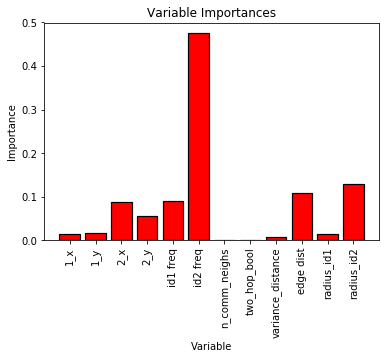

In [26]:
# list of x locations for plotting
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [27]:
from sklearn.metrics import f1_score
#model evaluation
print(confusion_matrix(Y_test,forest_pred))
print(classification_report(Y_test,forest_pred))
print(accuracy_score(Y_test, forest_pred))


average_precision = average_precision_score(Y_test, forest_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

print('Micro F1 Score:{}, Binary F1 score:{}'.format(f1_score(Y_test, forest_pred, average='micro'),f1_score(Y_test, forest_pred, average='binary')))

[[9946 1903]
 [1410 2439]]
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86     11849
         1.0       0.56      0.63      0.60      3849

    accuracy                           0.79     15698
   macro avg       0.72      0.74      0.73     15698
weighted avg       0.80      0.79      0.79     15698

0.7889540068798573
Average precision-recall score: 0.45
Micro F1 Score:0.7889540068798573, Binary F1 score:0.5955316811134171


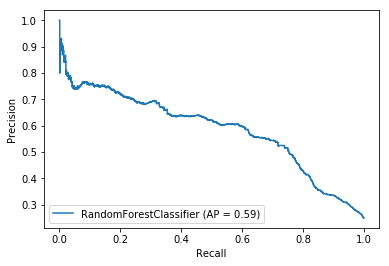

In [28]:
disp = plot_precision_recall_curve(clf, X_test, Y_test)
# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))

## now with train test split fit on real data and then train-test split to see how the performance is




In [30]:
X_tr, X_check, y_tr, y_check = train_test_split(X_test, Y_test, test_size=0.33, random_state=42)

clf = RandomForestClassifier(max_depth=6,n_estimators=100)

clf.fit(X_tr,y_tr)
forest_pred3 = clf.predict(X_check)
clf.score(X_check,y_check)

print(classification_report(y_check,forest_pred3))
print(accuracy_score(y_check, forest_pred3))
print('Micro F1 Score:{}, Binary F1 score:{}'.format(f1_score(y_check, forest_pred3, average='micro'),f1_score(y_check, forest_pred3, average='binary')))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      3919
         1.0       0.85      0.86      0.85      1262

    accuracy                           0.93      5181
   macro avg       0.90      0.91      0.90      5181
weighted avg       0.93      0.93      0.93      5181

0.9278131634819533
Micro F1 Score:0.9278131634819533, Binary F1 score:0.8532182103610675


## NOW RANDOM FOREST GRIDSEARCH FOR PARAMS AND SETTINGS

In [ ]:
best_rf = RandomForestClassifier(max_depth=30, max_features='log2',n_estimators=110)

best_rf.fit(X_train,Y_train)
forest_pred2 = clf.predict(X_test)
print(clf.score(X_test,Y_test))
print(recall_score(Y_test,forest_pred2))
print('Micro F1 Score:{}, Binary F1 score:{}'.format(f1_score(Y_test, forest_pred2, average='micro'),f1_score(Y_test, forest_pred2, average='binary')))

In [ ]:
from sklearn.metrics import precision_score
print(precision_score(Y_test,forest_pred2, average='macro'))
print(precision_score(Y_test,forest_pred2,average='micro'))
print(precision_score(Y_test,forest_pred2,average='weighted'))
print(precision_score(Y_test,forest_pred2,average='binary'))

print(classification_report(Y_test,forest_pred2))



average_precision = average_precision_score(Y_test, forest_pred2)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

## plot trees to see decision paths


In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
tree = clf.estimators_[5]# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

#needs adjustment sohuld be len(feature_list) == len(features) 
feature_list = ['1_x','1_y','2_x','2_y','id1 freq','id2 freq','edge dist','radius_id1','radius_id2']
# Pull out one tree from the forest
tree = clf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'rfc_edge_classification.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('rfc_edge_classification.dot')

# Write graph to a png file
os.chdir('/home/ikira/poincare-embeddings/plots')
graph.write_png('rfc_edge_classification.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 6 )
rf_small.fit(X_train,Y_train)# Extract the small tree
tree_small = rf_small.estimators_[5]# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
os.chdir('/home/ikira/poincare-embeddings/plots')
graph.write_png('small_tree.png')

## Gradient Boosting Classifier

## XGBoost

## Light GBM